## We are developing a package to calculate the discretized Koopman operator to obtain a computational approach of error for diffusion coefficients of systems with noise from Adjoint Methods.

In [1]:
using RigorousAdjointKoopman#This is a development version. To install the latest stable version, use:
# using Pkg
# Pkg.add("RigorousAdjointKoopman")

## Example:

Let consider $D:[0,1]\to [0,1]$, where $T(x) = 2x + 0.01\sin(2\pi x) \mod(1)$.

In [2]:
function D(x) 
    if 0<= x < 1/2
        return 2*x + 0.01*sin(2*pi*x)
    elseif 1/2 <= x <= 1
       return (2*x - 1) + 0.01*sin(2*pi*x)
    end
end

D (generic function with 1 method)

In [3]:
using Plots

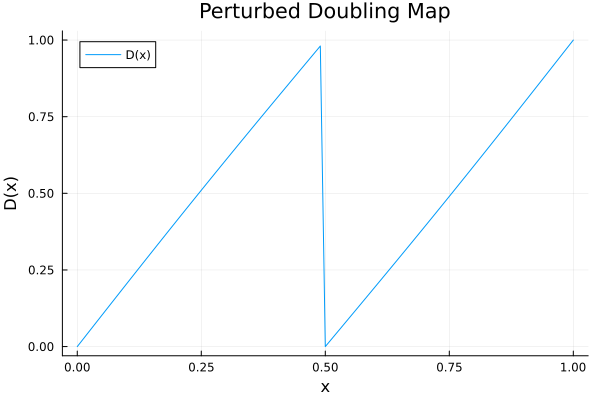

In [4]:
plot(D, 0:0.01:1, label="D(x)", title="Perturbed Doubling Map", xlabel="x", ylabel="D(x)")

## Let’s declare the basis of Hat functions.

$$
h_i(x) =
\begin{cases}
N({x - x_{i-1}}), & x \in [x_{i-1}, x_i], \\
N({x_{i+1} - x}), & x \in [x_i, x_{i+1}], \\
0, & \text{otherwise}.
\end{cases}
$$

In [5]:
N = 256
B = HatNP(N)

HatNP{LinRange{Float64, Int64}}(LinRange{Float64}(0.0, 1.0, 257))

## Using the discretization via the projection operator $\Pi_{\delta} \sum_{i=1}^N \phi(x_i) h_i(x)$, we can approximate $K$

In [6]:
K_delta = assemble_Koopman_boundary_condition(B, D, 1/4)#Here when we get a big noise the matrix is not markov. Arrange the assemble.

257×257 Matrix{IntervalArithmetic.Interval}:
  [0.00781238, 0.00781262]    …  [-1.18746e-07, 1.18746e-07]
  [0.00781238, 0.00781262]       [-1.18746e-07, 1.18746e-07]
  [0.00781238, 0.00781262]       [-1.18746e-07, 1.18746e-07]
  [0.00781238, 0.00781262]       [-1.18746e-07, 1.18746e-07]
  [0.00781238, 0.00781262]       [-1.18746e-07, 1.18746e-07]
  [0.00781238, 0.00781262]    …  [-1.18746e-07, 1.18746e-07]
  [0.00781238, 0.00781262]       [-1.18746e-07, 1.18746e-07]
  [0.00781238, 0.00781262]       [-1.18746e-07, 1.18746e-07]
  [0.00781238, 0.00781262]       [-1.18746e-07, 1.18746e-07]
  [0.00781238, 0.00781262]       [-1.18746e-07, 1.18746e-07]
  [0.00781238, 0.00781262]    …  [-1.18746e-07, 1.18746e-07]
  [0.00781238, 0.00781262]       [-1.18746e-07, 1.18746e-07]
  [0.00781238, 0.00781262]       [-1.18746e-07, 1.18746e-07]
   ⋮                          ⋱  
 [-1.18746e-07, 1.18746e-07]  …   [0.00781238, 0.00781262]
 [-1.18746e-07, 1.18746e-07]      [0.00781238, 0.00781262]
 [-1.18746

#### Assume there exists a stationary probability measure $\mu$ such that $\mu K=\mu$.

For an observable $\phi:[-1,1]\to\mathbb{R}$, where $\phi(x) = x^2$ we have:

In [15]:
ϕ(x) = x^2

ϕ (generic function with 1 method)

 Using the discretization via the projection operator again.

In [17]:
psi_delta = [ϕ(i/N) for i in 0:N]

257-element Vector{Float64}:
 0.0
 1.52587890625e-5
 6.103515625e-5
 0.0001373291015625
 0.000244140625
 0.0003814697265625
 0.00054931640625
 0.0007476806640625
 0.0009765625
 0.0012359619140625
 0.00152587890625
 0.0018463134765625
 0.002197265625
 ⋮
 0.9159088134765625
 0.92340087890625
 0.9309234619140625
 0.9384765625
 0.9460601806640625
 0.95367431640625
 0.9613189697265625
 0.968994140625
 0.9766998291015625
 0.98443603515625
 0.9922027587890625
 1.0

The invariance $\mu K=\mu$ implies, for any test function $g$,
$$
\mu\big((Id-K)g\big)=0.
$$

### Poisson equation for the Koopman operator

Let $K$ be the Koopman operator and  $\phi$ an observable.
We want to find a function $g$ and a constant $c$ such that

$$
(Id - K) g = \phi - c,
$$

together with the normalization condition

$$
\int g \, d\mu = 0.
$$

Integrating both sides of the Poisson equation and using the invariance of
the measure $\mu$, we obtain

$$
c = \int \phi \, d\mu.
$$

#### Solving the Poisson equation allows you to decompose:


$$
\phi - \int \phi \, d\mu  = g -g\circ T,
$$

which is fundamental for:

- Ergodic sums

- Central limit theorems

- Variance formulas

- Rigorous error bounds

#### Approximate solution and residual

Suppose
- $\tilde g$ is an approximate solution.

- $\tilde c$ is a approximate mean.


Define the residual

$$
r := (Id - K)\tilde g - (\phi - \tilde c).
$$


This measures how badly the Poisson equation is violated.

Then, integrating with respect to $\mu$,

$$
\int r \, d\mu
=
\int (Id - K)\tilde g \, d\mu
-
\int (\phi - \tilde c) \, d\mu.
$$

Since $\mu$ is invariant under $K$,


- $\int (Id - K)\tilde g \, d\mu = 0$,


and therefore

$$
c - \tilde c = \int r \, d\mu.
$$


The error in the approximation $\tilde c$ of the true average $c$
is exactly the integral of the residual:

$$
|c - \tilde c| \le \int |r_{\delta}| \, d\mu + \int|r-r_{\delta}|.
$$
Thus, controlling the residual gives a rigorous error bound on the computed  by $\tilde r_\delta$.


### We estimate $\tilde{c}$ by using Birkhoff averages:

In [18]:
sum_c = 0
M = 100000
X = rand()
for i in 1:M
    X = π_B_C(D(X) + 0.1*(2*rand()-1))
    sum_c += ϕ(D(X))
end
tilde_c  = sum_c / M

0.3333609141982869

### Now let’s calculate a candidate for $g$. A good candidate $g$ satisfies:




If the system is mixing and  $\phi \in L^2(\mu)$, a formal solution of the
Poisson equation
$$
(Id - K) g = \phi - \int \phi \, d\mu
$$
is given by the Neumann series:

$$
g
=
\sum_{n=0}^{\infty} K^n \bigl(\phi - \int \phi \, d\mu).
$$

#### To use the computed we are estimating the values of were finite that we can work with the computer.


$$
\tilde g = \sum_{n=0}^{N} K^n \bigl( \phi - \tilde c \bigr)
$$

In [19]:
using IntervalArithmetic

In [20]:
tilde_g = zeros(N+1)
Kc = mid.(K_delta)
w = psi_delta .- tilde_c 
for i in 1:1000
    tilde_g += w
    w = Kc*w
end
return tilde_g

257-element Vector{Float64}:
 -3.8168344123096847
 -3.816499595016504
 -3.815495113380462
 -3.81382086008823
 -3.8114764404954826
 -3.808461275627182
 -3.8047749838695837
 -3.8004176900059177
 -3.7953967854573145
 -3.7897244392149636
 -3.7834079107282603
 -3.776439222744618
 -3.7688075108676444
  ⋮
 -1.5362502963891553
 -1.5195717089195757
 -1.5037283221603905
 -1.4887098945677815
 -1.4745229203164172
 -1.4611826428929773
 -1.4486945217708473
 -1.4370581798973563
 -1.4262728075533944
 -1.4163373853828065
 -1.407251294196795
 -1.399014289710119

### Then we have that $\tilde r_{\delta}$:

In [22]:
tilde_r = maximum([sup(x) for x in abs.((psi_delta.-tilde_c)+(K_delta*tilde_g-tilde_g))])#this is the rigorous bound on the error infinity norm.

0.003020099001049603